# Task 13 – Neural nets II

_All credit for this jupyter notebook tutorial goes to the book "Hands-On Machine Learning with Scikit-Learn & TensorFlow" by Aurelien Geron. Modifications were made in preparation for the hands-on sessions._

# Setup

First, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Function to save a figure. This also decides that all output files 
# should stored in the subdirectorz 'classification'.
PROJECT_ROOT_DIR = "."
EXERCISE = "neural_nets_ii"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "output", EXERCISE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Implementing a non-saturating activation function

One very popular non-saturating activation is the ReLU, except for the problem that it "dies" at its low end. To solve this problem, we can define a "leaky" ReLU, as discussed in the lecture. Can you implement it?

Saving figure leaky_relu_plot


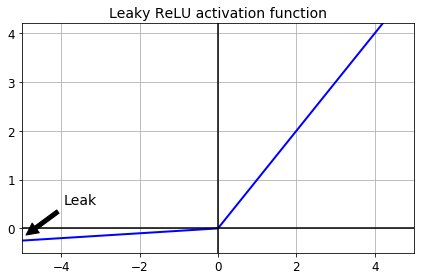

In [2]:
# Implement the leaky ReLU function here.
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

# Just to plot the leaking effect.
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

It can also be easily implemented in tensorflow. The method to use should be [tf.maximum](https://www.tensorflow.org/api_docs/python/tf/math/maximum). Can you add the missing definition?

Don't be surprised by possibel deprecation messages for `tf.layers`.  This is because tensorflow is completely changing their API structure for version 2, which is coming soon ... But at the moment, the deprecation warnings are nothing to worry about.

In [3]:
import tensorflow as tf

reset_graph()

n_inputs = 20  # Arbitrary number of inputs
n_hidden1 = 20 # Arbitrary number of nodes in hidden layer

# Define a placeholder for the inputs.
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# Define the leake ReLU. Can you add the definition?
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

# And now we could use it like this:
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


Let's (once again) grab the MNIST dataset, the one with the handwritten digits. Let's try to build a simple neural net on this dataset using the leaky ReLU that we just defined!

In [4]:
reset_graph()

n_inputs = 28 * 28  # pixel size of the input
n_hidden1 = 300     # Arbitrary size of a first hidden layer
n_hidden2 = 100     # Arbitrary size of a second hidden layer
n_outputs = 10      # Number of output nodes, one for each digit

# Retrieve our input features, and the labels of the instances.
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# We didn't really discuss name scopes in this tutorial,
# but there were mentioned in the lecture. They basically
# help to 'sort' things in tensorflow, e.g. when using
# tensorboard to display the model.

# Let's define two hidden layers with our leaky ReLU and one output
# layer from the second hidden layer.
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
# Define the loss function, we'll use the cross entropy.
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# Define a learning rate for the training, and use a
# gradient-descent optimiser for the training to minimise
# the loss function.
learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

# Evaluate the network performance by comparing with y.
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Remember that this is _only_ graph building, we haven't done anything yet! This will only be done in the next block of code. First, let's load the data (this might take a moment):

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Bring the date 'in shape', i.e. into 28x28 pixels, and
# also divide the values by 255 (that's the bit depth).
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# Also split into training and validation sets.
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [6]:
# Define a short function to shuffle the data into mini-batches.
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# And define the number of epochs and the batch size.
n_epochs = 40
batch_size = 50

# Now we finally run the training (this will take a while!) ...
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9658
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9762
25 Batch accuracy: 1.0 Validation accuracy: 0.9774
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


# Batch Normalisation

The following model implements two hidden layers, each of which use the ELU activation function. The activation function is already implemented as a separate step in the model to make your life easier. Can you implement batch normalisation for each of the hidden layers and the output? The class to use is [tf.layers.batch_normalization](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization).

Again, you might see deprecation warnings for this class (also on the documentation page).

In [7]:
reset_graph()

n_inputs = 28 * 28  # pixel size of the input
n_hidden1 = 300     # Arbitrary size of a first hidden layer
n_hidden2 = 100     # Arbitrary size of a second hidden layer
n_outputs = 10      # Number of output nodes, one for each digit

# Placeholder for the input data.
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# This is basically a placeholder with a switch whether we're looking
# at training data or not. This will be needed to tell the batch
# normalisation how the normalisation is evaluated (batch vs. total).
training = tf.placeholder_with_default(False, shape=(), name='training')

# Build the first hidden layer. Can you add batch normalisation here?
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

# Build the second one. Again, can you add batch normalisation?
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

# And the same for the output layer?
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

# As before, define the cross entropy and loss.
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# As before, gradient-descent optimiser to minimise the loss.
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

# As before, evaluate on the accuracy by comparing to y.
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.


Now we're ready to run the model. Again, this might take a moment. Can you guess what the `UPDATE_OPS` function is doing for batch normalisation?

In [8]:
n_epochs = 20
batch_size = 200

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8824
1 Validation accuracy: 0.9094
2 Validation accuracy: 0.9196
3 Validation accuracy: 0.9282
4 Validation accuracy: 0.9318
5 Validation accuracy: 0.9376
6 Validation accuracy: 0.9438
7 Validation accuracy: 0.947
8 Validation accuracy: 0.9492
9 Validation accuracy: 0.952
10 Validation accuracy: 0.9536
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9576
13 Validation accuracy: 0.9622
14 Validation accuracy: 0.9632
15 Validation accuracy: 0.9628
16 Validation accuracy: 0.9658
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.9678
19 Validation accuracy: 0.9686


That's it! But actually, isn't this worse than what we had before with the leaky ReLU and _no_ batch normalisation? So that means that a "better" activation function plus batch normalisation give a worse result than the cheap leaky ReLU? Do you have any idea why?

# Alternative (and faster) optimisers

There are various optimisers available in tensorflow, all of which tend to be a lot faster than the 'standard' gradient-descent optimiser. Below you find the tensorflow implemetations of:
* Momentum optimisation ([tf.train.MomentumOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer))
* Nesterov momentum optimisation
* Adaptive gradient (AdaGrad) optimisation ([tf.train.AdagradOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer))
* RMSProp optimisation ([tf.train.RMSPropOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer))
* Adaptive moment estimation (Adam) optimisation ([tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer))

All of these can easily be used in the above neural net(s) trained on the MNIST dataset. Just replace the current optimizer of the 'train' scope of the model. Can you make out differences between the optimizers? Do they considerably speed up the convergence and/or the training cycle?

In [9]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Regularisation via dropout

The most common regularisation technique for neural nets is dropout. Can you implement dropout in the following example? The class to use in tensorflow is [tf.layers.dropout](https://www.tensorflow.org/api_docs/python/tf/layers/dropout).

Again, you might see deprecation warnings because of tensorflow v2 coming soon ...

In [10]:
reset_graph()

# Placeholder for the input data.
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# This is basically a placeholder with a switch whether we're looking
# at training data or not. This will be needed to tell the batch
# normalisation how the normalisation is evaluated (batch vs. total).
training = tf.placeholder_with_default(False, shape=(), name='training')

# Set the dropout rate.
dropout_rate = 0.5

# First, let's implement dropout for the input X. Can you add it?
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

# Build the actual NN with two hidden layers.
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    # Now the first layer was created. Can you add dropout for it?
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    # And for the second one, too?
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    # Build the output layer.
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

# As before, define the cross entropy and loss.
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

# Let's use momentum optimisation this time.
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

# As before, evaluate on the accuracy by comparing to y.
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now let's start the training!

In [11]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9296
1 Validation accuracy: 0.9512
2 Validation accuracy: 0.9562
3 Validation accuracy: 0.9618
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9672
6 Validation accuracy: 0.9672
7 Validation accuracy: 0.9708
8 Validation accuracy: 0.9728
9 Validation accuracy: 0.971
10 Validation accuracy: 0.9708
11 Validation accuracy: 0.9728
12 Validation accuracy: 0.9708
13 Validation accuracy: 0.9752
14 Validation accuracy: 0.973
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9748
17 Validation accuracy: 0.9764
18 Validation accuracy: 0.9742
19 Validation accuracy: 0.9752
